# Máquinas de soporte vectorial (SVM)

## 1. Importación de paquetes y librerías

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve, RepeatedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
import warnings
warnings.filterwarnings('ignore')

## 2. Importación de datos

In [2]:
loc=r"../interacciones_mensuales.csv"
data=pd.read_csv(loc,encoding="latin1",index_col=False,decimal=",",engine="python")
data = data.drop(data.columns[-20:], axis=1)

data=data[((data.Total-data.Total.mean()) / data.Total.std()).abs() <3]

#data=pd.get_dummies(data,columns=["Clon","Nivel","Exposicion"])

In [3]:
X = data.drop(["Total","Year","Cod",'P_days'],axis=1) # Asignar variables independientes
nombres = data.drop(["Total","Year","Cod",'P_days'],axis=1).columns # Nombre de las variables dependientes
y = data['Total'] # Asignar variable dependiente

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

scaler= StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Identificación de hiper parámetros

In [4]:
svr = GridSearchCV(SVR(kernel='linear', gamma=1,epsilon=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2,1e3],
                               "kernel":["linear","rbf","poly"],
                               "gamma": np.logspace(-2, 2, 5),
                               "epsilon":np.logspace(0, 1, 5)})
svr.fit(X_train_scaled,y_train);

In [5]:
svr.best_estimator_, svr.best_score_

(SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=10.0, gamma=0.01,
   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 0.3644664174164851)

## 3. Ajuste y validación

### Hold out

In [6]:
R_2 = []
RMSE = []
MAE = []
CRM = []
pred=np.array(0)
obs=np.array(0)

for i in range(100):

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20) #Hacer partición de datos en entrenamiento y prueba

    scaler= StandardScaler().fit(X_train)
    X_train_scaled=scaler.transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    
    cacaoSVMModel=SVR(kernel=svr.best_params_["kernel"],C=svr.best_params_["C"], epsilon=svr.best_params_["epsilon"],
                     gamma=svr.best_params_["gamma"],max_iter=1500)
    cacaoSVMModel.fit(X_train_scaled,y_train)
    errorVector=y_test-cacaoSVMModel.predict(X_test_scaled)
    
    r_2=r2_score(y_test,cacaoSVMModel.predict(X_test_scaled))
    R_2.append(r_2)
    RMSE.append(np.linalg.norm((y_test-cacaoSVMModel.predict(X_test_scaled)),2)/np.sqrt(len(y_test)))
    MAE.append(median_absolute_error(y_test,cacaoSVMModel.predict(X_test_scaled)))
    CRM.append((sum(y_test)-sum(cacaoSVMModel.predict(X_test_scaled)))/sum(y_test))
    
    if r_2 >= max(R_2):
        pred = cacaoSVMModel.predict(X_test_scaled)
        obs = y_test
        X_Test = X_test_scaled
        y_Test = y_test
        model = cacaoSVMModel

In [7]:
print("R^2: %.4f" % np.mean(R_2))
print("RMSE: %.4f" % np.mean(RMSE))
print("MAE: %.4f" % np.mean(MAE))
print("CRM: %.4f" % (np.mean(CRM)))

R^2: 0.3509
RMSE: 28.7834
MAE: 15.3826
CRM: 0.1024


In [8]:
print("Mejor R^2: %.4f" % (r2_score(obs,pred)))
print("Mejor CRM: %.4f" % ((sum(obs)-sum(pred))/sum(obs)))

Mejor R^2: 0.4793
Mejor CRM: 0.1074


<Figure size 432x288 with 0 Axes>

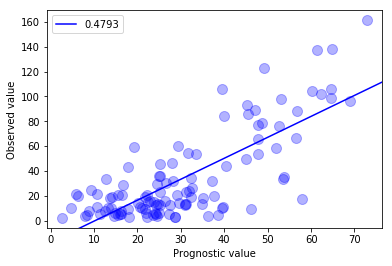

In [9]:
obs,pred = np.array(obs).flatten(), np.array(pred).flatten() 

plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()
ax.scatter(pred,obs,s=100,alpha=0.3,c="b")
line_fit=sm.OLS(obs,sm.add_constant(pred,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="b",label=round(r2_score(obs,pred),4))
plt.xlabel("Prognostic value")
plt.ylabel("Observed value")
plt.legend();

In [10]:
# Almacenar los datos de prueba
res=pd.DataFrame([np.array(pred).flatten(),np.array(obs).flatten()]).T
res.columns=["Pronosticado","Observado"]
res.to_csv("res_SVR.csv",decimal=",")

## Curva de aprendizaje

<module 'matplotlib.pyplot' from 'C:\\Users\\Usuario\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

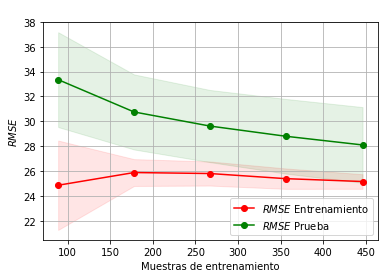

In [11]:
import Curva

X=data.drop(["Total","Year","Cod",'P_days'],axis=1).values # Asignar variables independientes
y=data['Total'].values # Asignar variable dependiente

# Normalización de los atributos
scaler= StandardScaler().fit(X)
X_scaled=scaler.transform(X)

title = " "

cv = ShuffleSplit(n_splits=10, test_size=0.2)
estimator = SVR(kernel=svr.best_params_["kernel"],C=svr.best_params_["C"], epsilon=svr.best_params_["epsilon"],
                     gamma=svr.best_params_["gamma"],max_iter=1500)

Curva.plot_learning_curve(estimator, title, X_scaled, y, cv=cv, n_jobs=4)
#plt.savefig("LC SVM.jpg",dpi=600);

## 4. Importancia relativa de las variables

In [12]:
predictores = nombres
X_ = pd.DataFrame(X_Test,columns=nombres)
y = y_Test

In [13]:
R_2 = []
RMSE = []
MAE = []

for i in predictores:
    
    X = X_.copy()
    X[i] = 0
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state= 0) #Hacer partición de datos en entrenamiento y prueba

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    r_2 = r2_score(y_test, model.predict(X_test_scaled))
    R_2.append(r_2)
    RMSE.append(np.linalg.norm((y_test-model.predict(X_test_scaled)),2)/np.sqrt(len(y_test)))
    MAE.append(median_absolute_error(y_test,model.predict(X_test_scaled)))

In [14]:
dic = {"R2":R_2,"RMSE":RMSE, "MAE":MAE}
DF = pd.DataFrame(dic,index=predictores)
DF["RI"] = RMSE/DF.RMSE.sum()
DF.sort_values(by = "RI",ascending=False,inplace = True)

## Estrategia de oscilación

In [15]:
var = ['T_avg','T_avg _prev',"P_accu", "P_accu_prev","Rad_accu","Rad_accu_prev1","Rad_accu_prev2","Hum_avg","EC_avg"]
y = y_Test

In [16]:
R_2 = []
RMSE = []
MAE = []
pre = []
rango = []

for i in var:
        
    X = X_.copy()
    promedio = []
    
    for j in np.linspace(X[i].min(), X[i].max(),100):
        
        X[i] = j
    
        prediction = model.predict(X)
        
        pre.append(np.mean(prediction))
        promedio.append(np.mean(prediction))
        R_2.append(r2_score(y, prediction))
        RMSE.append(np.linalg.norm((y-prediction),2)/np.sqrt(len(y)))
        MAE.append(median_absolute_error(y,prediction))
    
    rango.append(max(promedio)-min(promedio))

In [17]:
dic = {}

for i in var:
    if i not in dic:
        dic[i] = np.linspace(X_[i].min(), X_[i].max(),100)

RMSE_1 = RMSE[:100]
RMSE_2 = RMSE[100:200]
RMSE_3 = RMSE[200:300]
RMSE_4 = RMSE[300:400]
RMSE_5 = RMSE[400:500]
RMSE_6 = RMSE[500:600]
RMSE_7 = RMSE[600:700]
RMSE_8 = RMSE[-100:]

PRE_1 = pre[:100]
PRE_2 = pre[100:200]
PRE_3 = pre[200:300]
PRE_4 = pre[300:400]
PRE_5 = pre[400:500]
PRE_6 = pre[500:600]
PRE_7 = pre[600:700]
PRE_8 = pre[-100:]

In [18]:
pde = pd.DataFrame(dic)
pde["RMSE_1"],pde["RMSE_2"],pde["RMSE_3"],pde["RMSE_4"],pde["RMSE_5"],pde["RMSE_6"],pde["RMSE_7"],pde["RMSE_8"] = RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8
pde["PRE_1"],pde["PRE_2"],pde["PRE_3"],pde["PRE_4"],pde["PRE_5"],pde["PRE_6"],pde["PRE_7"],pde["PRE_8"] = PRE_1,PRE_2,PRE_3,PRE_4,PRE_5,PRE_6,PRE_7,PRE_8
pde.to_csv("Evaluación_SVM.csv",decimal=",")

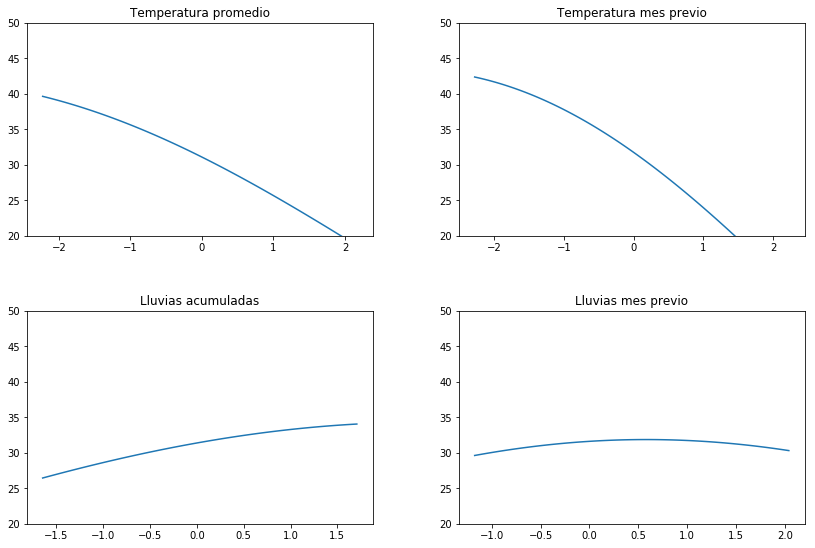

In [19]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.ylim(20,50)
plt.title("Temperatura promedio")
plt.plot(pde.T_avg,pde.PRE_1)

plt.subplot(2,2,2)
plt.ylim(20,50)
plt.title("Temperatura mes previo")
plt.plot(pde['T_avg _prev'],pde.PRE_2)

plt.subplot(2,2,3)
plt.ylim(20,50)
plt.title("Lluvias acumuladas")
plt.plot(pde.P_accu,pde.PRE_3)

plt.subplot(2,2,4)
plt.ylim(20,50)
plt.title("Lluvias mes previo")
plt.plot(pde.P_accu_prev,pde.PRE_4)

plt.subplots_adjust(top=0.92,bottom=0.05,left=0.05,right=0.95,
                   hspace=0.35,wspace=0.25)

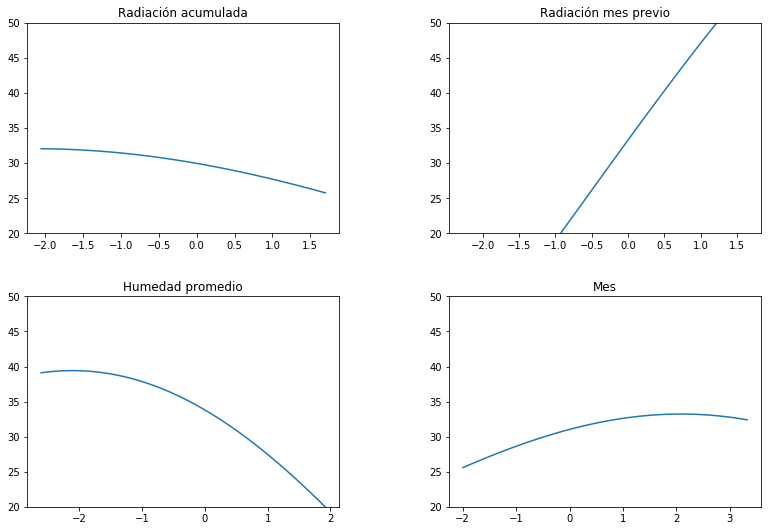

In [20]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.ylim(20,50)
plt.title("Radiación acumulada")
plt.plot(pde.Rad_accu,pde.PRE_5)

plt.subplot(2,2,2)
plt.ylim(20,50)
plt.title("Radiación mes previo")
plt.plot(pde.Rad_accu_prev1,pde.PRE_6)

plt.subplot(2,2,3)
plt.ylim(20,50)
plt.title("Humedad promedio")
plt.plot(pde.Hum_avg,pde.PRE_7)

plt.subplot(2,2,4)
plt.ylim(20,50)
plt.title("Mes")
plt.plot(pde.EC_avg,pde.PRE_8)

plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,
                   hspace=0.3,wspace=0.35)

In [21]:
new_dic ={}
for i,j in enumerate(var):
    if j not in new_dic:
        new_dic[j]=round(rango[i]/sum(rango),2)

pd.DataFrame(new_dic,index=np.linspace(0,1,1)).T

,0.0
T_avg,0.14
T_avg _prev,0.19
P_accu,0.05
P_accu_prev,0.01
Rad_accu,0.04
Rad_accu_prev1,0.35
Rad_accu_prev2,0.13
Hum_avg,0.04
EC_avg,0.05
